# Librerias

In [8]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression

# Carga de los datos

In [11]:
# Construir la ruta completa al archivo Excel
excel_file = "C:\\Users\\daniela.martinez\\OneDrive - IGAC\\Documentos\\Deriva\\Datos\\Seleccion_Datos_Grav_Deriva.xlsm"

# Solicitar el nombre de la hoja
sheet_name = 'Promedios'

# Leer la hoja específica del archivo Excel
try:
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    print(f"Datos cargados exitosamente de la hoja '{sheet_name}'")
    print(df.head(20))  # Mostrar las primeras filas de los datos cargados
except FileNotFoundError:
    print(f"Error: El archivo '{excel_file}' no se encuentra.")
except ValueError:
    print(f"Error: La hoja '{sheet_name}' no se encuentra.")

# Función para combinar la fecha y hora en una sola columna datetime
def combine_date_time(date_str, time_str):
    try:
        # Asegurarse de que time_str es una cadena de texto
        if not isinstance(time_str, str):
            raise ValueError("El tiempo debe ser una cadena de texto.")
        
        # Combinar la fecha y la hora en una cadena datetime
        datetime_str = f"{date_str} {time_str.strip()}"
        # Convertir la cadena a un objeto datetime
        return datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
    except ValueError as e:
        print(f"Error al combinar la fecha y hora: {e}")
        return None

# Convertir 'Date' a string y 'Time_Prom' a string
df['Date'] = df['Date'].astype(str)
df['Time_Prom'] = df['Time_Prom'].astype(str)

# Crear columna datetime combinando 'Date' y 'Time_Prom'
df['Datetime'] = df.apply(lambda row: combine_date_time(row['Date'], row['Time_Prom']), axis=1)

# Verificar si hay valores NaN en la columna Datetime
if df['Datetime'].isna().any():
    print("Se encontraron valores NaN en la columna 'Datetime'. Asegúrate de que todos los datos sean válidos.")
    print(df[df['Datetime'].isna()])  # Mostrar las filas con valores NaN

Datos cargados exitosamente de la hoja 'Promedios'
    /Station       Date Time_Prom  CorrGrav_Prom  DesvEst_Grav_Prom    LatGPS  \
0   68001012 2023-06-10  11:50:27    2189.089375           0.000250  7.100629   
1   68406018 2023-06-10  13:05:25    2159.619425           0.000465  7.110620   
2    14-SS-6 2023-06-10  14:41:50    2126.360975           0.000680  7.173279   
3   68307026 2023-06-10  15:52:10    2241.835300           0.000469  7.094560   
4   68092007 2023-06-10  16:55:00    2295.850700           0.000216  7.127937   
5   68081009 2023-06-10  18:05:21    2306.155750           0.000545  7.128266   
6   68081009 2023-06-10  18:27:04    2306.147375           0.000574  7.128266   
7   68092007 2023-06-10  19:13:37    2295.806475           0.000171  7.127890   
8   68307026 2023-06-10  20:05:29    2241.769075           0.000814  7.094554   
9    14-SS-6 2023-06-10  21:09:45    2126.283525           0.001153  7.173264   
10  68406018 2023-06-10  22:37:27    2159.554600          

# Calculo de la deriva

In [12]:
# Agrupar los datos por 'Station'
stations = df.groupby('/Station')

# Listas para almacenar los resultados
derivas = []
errores = []

# Iterar sobre cada estación para calcular la deriva
for station, group in stations:
    if len(group) == 2:  # Verifica si la estación tiene ida y vuelta
        # Extraer los valores de CorrGrav_Prom y Datetime en orden
        t1 = group.iloc[0]['Datetime']
        t2 = group.iloc[1]['Datetime']
        grav1 = group.iloc[0]['Prom_Grav_Tide_Corr']
        grav2 = group.iloc[1]['Prom_Grav_Tide_Corr']

        # Asegurarse de que t1 y t2 no sean None
        if t1 and t2:
            # Calcular la diferencia en gravedad y la deriva
            diferencia_gravedad = grav2 - grav1
            delta_t = (t2 - t1).total_seconds() / 3600  # Convertir la diferencia a horas
            deriva = diferencia_gravedad / delta_t

            # Almacenar los resultados
            derivas.append({
                '/Station': station,
                'Diferencia gravedad': diferencia_gravedad,
                'Deriva': deriva,
                'Time1': t1,
                'Time2': t2
            })
        else:
            errores.append(f"No se pudo calcular la deriva para la estación '{station}' debido a datos inválidos.")
    else:
        # Si no hay ida y vuelta, almacenar un mensaje de error
        errores.append(f"No se encuentra completo el circuito para la estación '{station}'.")

# Convertir los resultados en un DataFrame para visualizar mejor
df_derivas = pd.DataFrame(derivas)

# Ordenar el DataFrame de resultados por 'Time1' para mostrar en orden de ida
df_derivas = df_derivas.sort_values(by='Time1').reset_index(drop=True)

# Mostrar las derivas calculadas y los errores
print("Derivas Calculadas (en orden de toma de datos):")
print(df_derivas)

if errores:
    print("\nErrores:")
    for error in errores:
        print(error)

Derivas Calculadas (en orden de toma de datos):
   /Station  Diferencia gravedad    Deriva               Time1  \
0  68001012            -0.021425 -0.001798 2023-06-10 11:50:27   
1  68406018            -0.020175 -0.002116 2023-06-10 13:05:25   
2   14-SS-6            -0.011475 -0.001775 2023-06-10 14:41:50   
3  68307026            -0.006675 -0.001581 2023-06-10 15:52:10   
4  68092007            -0.004175 -0.001807 2023-06-10 16:55:00   
5  68081009            -0.000850 -0.002348 2023-06-10 18:05:21   

                Time2  
0 2023-06-10 23:45:23  
1 2023-06-10 22:37:27  
2 2023-06-10 21:09:45  
3 2023-06-10 20:05:29  
4 2023-06-10 19:13:37  
5 2023-06-10 18:27:04  


# Graficas

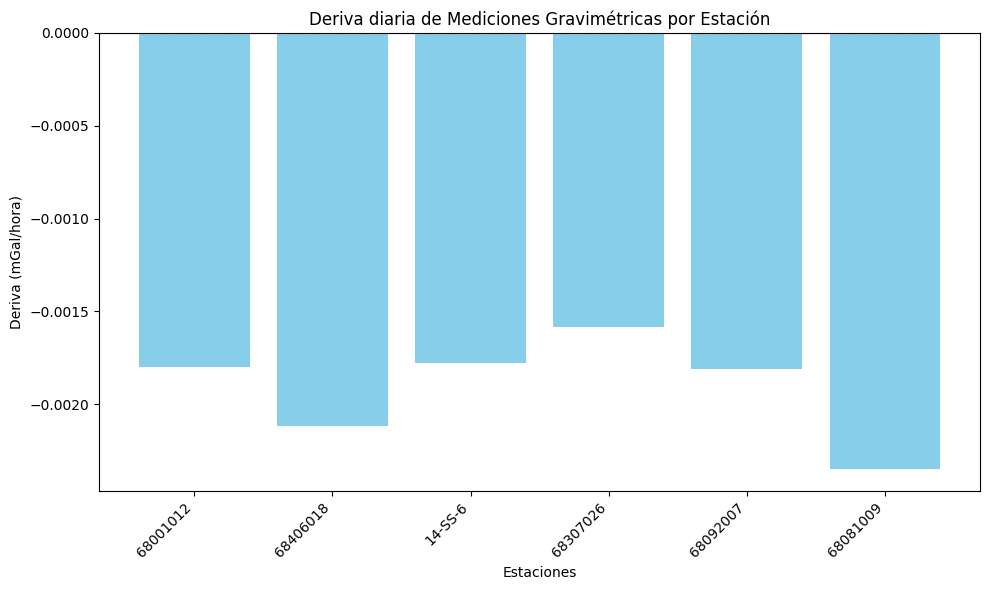

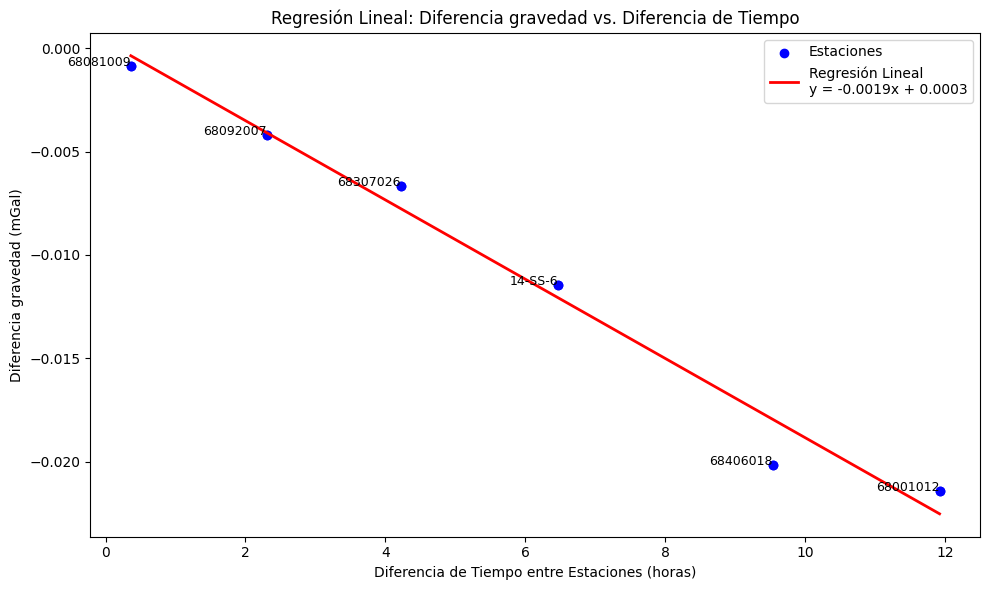

In [13]:
# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar la deriva usando los nombres de las estaciones como etiquetas
plt.bar(df_derivas['/Station'].astype(str), df_derivas['Deriva'], color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Estaciones')
plt.ylabel('Deriva (mGal/hora)')
plt.title('Deriva diaria de Mediciones Gravimétricas por Estación')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # Línea en y=0 para referencia

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45, ha='right')

# Ajustar el layout para que no se corten las etiquetas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Calcular la diferencia de tiempo entre las estaciones
df_derivas['Diferencia_Tiempo'] = (df_derivas['Time2'] - df_derivas['Time1']).apply(lambda x: x.total_seconds() / 3600)

# Preparar los datos para la regresión
X = df_derivas['Diferencia_Tiempo'].values.reshape(-1, 1)  # Diferencia de tiempo como variable independiente
y = df_derivas['Diferencia gravedad'].values  # Diferencia gravedad como variable dependiente

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir valores usando el modelo ajustado
y_pred = model.predict(X)

# Calcular la pendiente y la intersección
pendiente = model.coef_[0]
interseccion = model.intercept_

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos de datos con etiquetas
for i in range(len(X)):
    plt.scatter(X[i], y[i], color='blue')
    plt.text(X[i], y[i], df_derivas['/Station'][i], fontsize=9, ha='right')

# Graficar los puntos de datos
plt.scatter(X, y, color='blue', label='Estaciones')

# Graficar la línea de regresión
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regresión Lineal\ny = {pendiente:.4f}x + {interseccion:.4f}')

# Añadir etiquetas y título
plt.xlabel('Diferencia de Tiempo entre Estaciones (horas)')
plt.ylabel('Diferencia gravedad (mGal)')
plt.title('Regresión Lineal: Diferencia gravedad vs. Diferencia de Tiempo')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


# Extraer y almacenar información

In [15]:
# Solicitar al usuario la ruta donde se guardarán los productos
Nombre_Tabla = input("Ingrese el nombre del archivo: ")

ruta_archivo_texto = f"C:\\Users\\daniela.martinez\\OneDrive - IGAC\\Documentos\\Deriva\\Resultados\\{Nombre_Tabla}.txt"

# Convertir el DataFrame en una cadena de texto
df_derivas_str = df_derivas.to_string(index=False)

# Ejemplo de cómo guardar un archivo en la ruta especificada
try:
    with open(ruta_archivo_texto, 'w') as archivo:
        archivo.write(df_derivas_str)
    print(f"Archivo guardado exitosamente en {ruta_archivo_texto}")
except Exception as e:
    print(f"Ocurrió un error al guardar el archivo: {e}")



Archivo guardado exitosamente en /home/alejandrotabares/Documentos/IGAC/Drift/Datos/Prueba1213.txt
